# Random Forest Text Readability Classification
This notebook implements a Random Forest classifier for Arabic text readability level prediction.

## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import re
import time
import nltk
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.sparse import hstack
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

## 2. Data Loading and Initial Exploration

In [3]:
# Load CSV file
df = pd.read_csv("/kaggle/input/bayyin-data/bayyin_dataset.csv")
df = df.dropna(subset=['Readability_Level']).copy()
# Check columns
print(df.columns)


Index(['ID', 'Sentence', 'Word_Count', 'Word', 'Lex', 'D3Tok', 'D3Lex',
       'Readability_Level', 'Document', 'Source', 'Book', 'Author', 'Domain',
       'Text_Class', 'Dataset_Source'],
      dtype='object')


## 3. Arabic Text Preprocessing Utilities

In [4]:
# --- 1. ARABIC PREPROCESSING UTILITIES ---

# Comprehensive list of Arabic diacritics (Harakat) to be removed
ARABIC_DIACRITICS = re.compile(r'[\u064B-\u0652]')

def remove_diacritics(text):
    """Removes Arabic diacritics (Harakat) from text."""
    return ARABIC_DIACRITICS.sub('', text)

def remove_non_alpha(text):
    """Removes non-alphanumeric characters except spaces."""
    # Keeps Arabic letters, English letters (if any), and spaces
    return re.sub(r'[^\w\s]', '', text)

def clean_text(text):
    """Applies basic cleaning and normalization."""
    if pd.isna(text) or not text:
        return ""
    text = str(text).lower()
    text = remove_diacritics(text)
    text = remove_non_alpha(text)
    return re.sub(r'\s+', ' ', text).strip() # Normalize whitespace

def calculate_morph_complexity(tokens_col):
    """
    Calculates the average number of morphological tokens (D3Tok/D3Lex) per original word.
    A higher value indicates more complex agglutination.
    """
    if pd.isna(tokens_col) or not tokens_col:
        return 1.0 # Default complexity for empty/missing data

    original_words = tokens_col.split()
    total_morph_units = 0
    total_words = 0

    for word in original_words:
        # Check for the '+' delimiter, which separates morphological units
        morph_units = word.count('+') + 1
        total_morph_units += morph_units
        total_words += 1

    return total_morph_units / total_words if total_words > 0 else 1.0
# Drop rows where the target or essential feature columns are missing
df.dropna(subset=['Sentence', 'Lex', 'Word_Count', 'Readability_Level'], inplace=True)

# Encode the target variable (Readability_Level) to integers (0 to 5)
target_le = LabelEncoder()
df['Readability_Level_Encoded'] = target_le.fit_transform(df['Readability_Level'])
print(f"Readability Levels Mapped to: {dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))}")

# Apply cleaning to the text columns
df['Clean_Lex'] = df['Lex'].apply(clean_text)

Readability Levels Mapped to: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


## 4. Feature Engineering - Statistical Features

In [5]:
print("Calculating statistical features...")
# 1. Word Count (already present, but ensure type)
df['Word_Count'] = df['Word_Count'].astype(int)

# 2. Average Word Length (using the cleaned root/lemma column)
df['Avg_Lex_Length'] = df['Clean_Lex'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)

# 3. Lexical Density (Type-Token Ratio using Lexemes)
df['Lexical_Density'] = df['Clean_Lex'].apply(
    lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0
)

# 4. Morphological Complexity (using D3Tok column)
# This captures how many morphemes (pre-/suf-fixes) are attached to each word
df['Morph_Complexity'] = df['D3Tok'].apply(calculate_morph_complexity)


# --- B. Text Vectorization Features (TF-IDF) ---
print("Fitting TF-IDF Vectorizer...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2) # Use unigrams and bigrams
)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Lex'])
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

# --- C. Statistical Feature Matrix (for combination) ---
X_stats_numeric = df[['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']].values.astype(np.float64)
print(f"Statistical Matrix Shape: {X_stats_numeric.shape}")

Calculating statistical features...
Fitting TF-IDF Vectorizer...
TF-IDF Matrix Shape: (46410, 5000)
Statistical Matrix Shape: (46410, 4)


## 5. Data Preparation for Modeling

In [6]:
# Define the numerical and categorical feature matrix
X_stats = df[['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']].values

# FIX: Explicitly convert the dense matrix to a numeric type (float64)
X_stats_numeric = X_stats.astype(np.float64)

# Combine all feature matrices: Statistical + Categorical + TF-IDF
X = hstack([
    X_stats_numeric,
    tfidf_matrix
]).tocsr()

y = df['Readability_Level_Encoded']

print(f"\nFinal Feature Matrix Shape (X): {X.shape}")
print(f"Target Vector Shape (y): {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # Stratify ensures equal distribution of readability levels
)


Final Feature Matrix Shape (X): (46410, 5004)
Target Vector Shape (y): (46410,)


## 6. Evaluation Metrics Definition

In [7]:
# --- 4. EVALUATION METRICS & PLOTTING ---

def calculate_qwk(y_true, y_pred):
    """Calculates Quadratic Weighted Kappa"""
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def calculate_accuracy_within_one(y_true, y_pred):
    """Calculates accuracy within +/- 1 level"""
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)

    # Calculate the absolute difference
    diff = np.abs(y_true_np - y_pred_np)

    # Count as "correct" if the difference is 0 or 1
    correct = diff <= 1

    # Return the mean (accuracy)
    return np.mean(correct)

def plot_normalized_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """Plots a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    # Normalize by the number of true instances (rows)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Normalized {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## 7. Load AraBERT Embeddings

In [8]:
# Load AraBERT Embeddings from PKL file
X_train_pkl, X_test_pkl, y_train_pkl, y_test_pkl = joblib.load("/kaggle/input/train-test-split/train_test_split.pkl")

print(f"Loaded AraBERT data. X_train shape: {X_train_pkl.shape}, X_test shape: {X_test_pkl.shape}")

Loaded AraBERT data. X_train shape: (37128, 772), X_test shape: (9282, 772)


## 8. Random Forest Model - TF-IDF Features Only

In [23]:
# Train Random Forest on TF-IDF Features
X= tfidf_matrix.tocsr()
y = df['Readability_Level_Encoded'].values

X_train_Tfidf, X_test_Tfidf, y_train_Tfidf, y_test_Tfidf = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # Stratify ensures equal distribution of readability levels
)
print("\nTraining Random Forest with TF-IDF ...")
rf_model_Tfidf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
rf_model_Tfidf.fit(X_train_Tfidf, y_train_Tfidf)
print(f"Model training finished in {time.time() - start_time:.2f} seconds.")


Training Random Forest with TF-IDF ...
Model training finished in 7.01 seconds.


### 8.1. Evaluation - TF-IDF Model


 Model Evaluation (TF-IDF only):
              precision    recall  f1-score   support

           0      0.412     0.931     0.572      1547
           1      0.556     0.342     0.423      1547
           2      0.505     0.359     0.420      1547
           3      0.443     0.100     0.163      1547
           4      0.468     0.441     0.455      1547
           5      0.510     0.635     0.566      1547

    accuracy                          0.468      9282
   macro avg      0.482     0.468     0.433      9282
weighted avg      0.482     0.468     0.433      9282

Accuracy (TF-IDF only): 0.4682
QWK (TF-IDF only): 0.6055
Accuracy ±1 (TF-IDF only): 0.7053


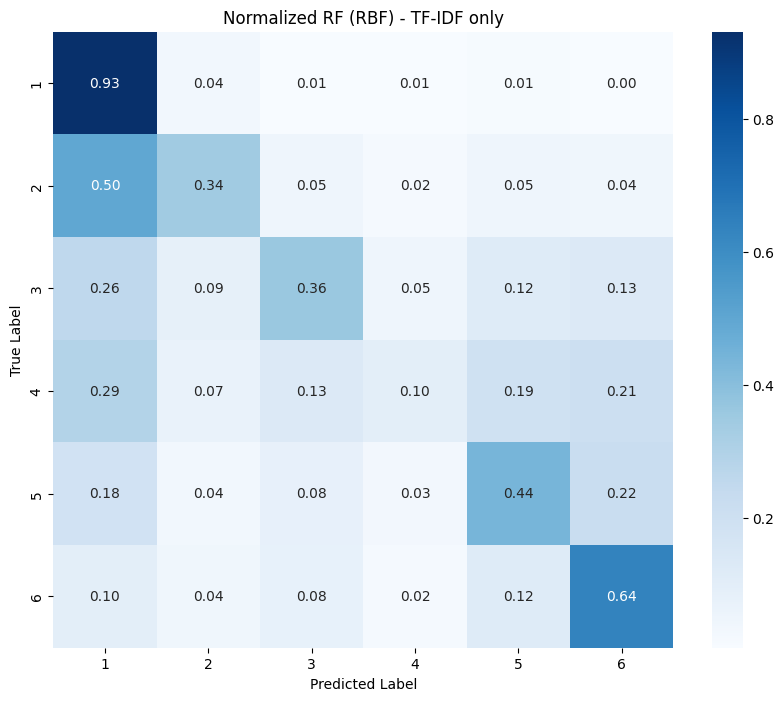

In [24]:
y_pred_Tfidf = rf_model_Tfidf.predict(X_test_Tfidf)
print("\n Model Evaluation (TF-IDF only):")
print(classification_report(y_test_Tfidf, y_pred_Tfidf, digits=3))

acc_rf_tfidf = accuracy_score(y_test_Tfidf, y_pred_Tfidf)
qwk_rf_tfidf = calculate_qwk(y_test_Tfidf, y_pred_Tfidf)
acc1_rf_tfidf = calculate_accuracy_within_one(y_test_Tfidf, y_pred_Tfidf)

print(f"Accuracy (TF-IDF only): {acc_rf_tfidf:.4f}")
print(f"QWK (TF-IDF only): {qwk_rf_tfidf:.4f}")
print(f"Accuracy ±1 (TF-IDF only): {acc1_rf_tfidf:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_Tfidf, y_pred_Tfidf, class_names_labels, title='RF (RBF) - TF-IDF only')

## 9. Random Forest Model - Statistical + TF-IDF Features


Training RF with Statistical and TF-IDF ...

 Model Evaluation (Statistical and TF-IDF):
              precision    recall  f1-score   support

           0      0.575     0.806     0.671      1547
           1      0.533     0.569     0.551      1547
           2      0.495     0.503     0.499      1547
           3      0.449     0.148     0.223      1547
           4      0.497     0.537     0.516      1547
           5      0.556     0.614     0.584      1547

    accuracy                          0.530      9282
   macro avg      0.517     0.530     0.507      9282
weighted avg      0.517     0.530     0.507      9282

Accuracy (Statistical and TF-IDF): 0.5295
QWK (Statistical and TF-IDF): 0.6838
Accuracy ±1 (Statistical and TF-IDF): 0.7644


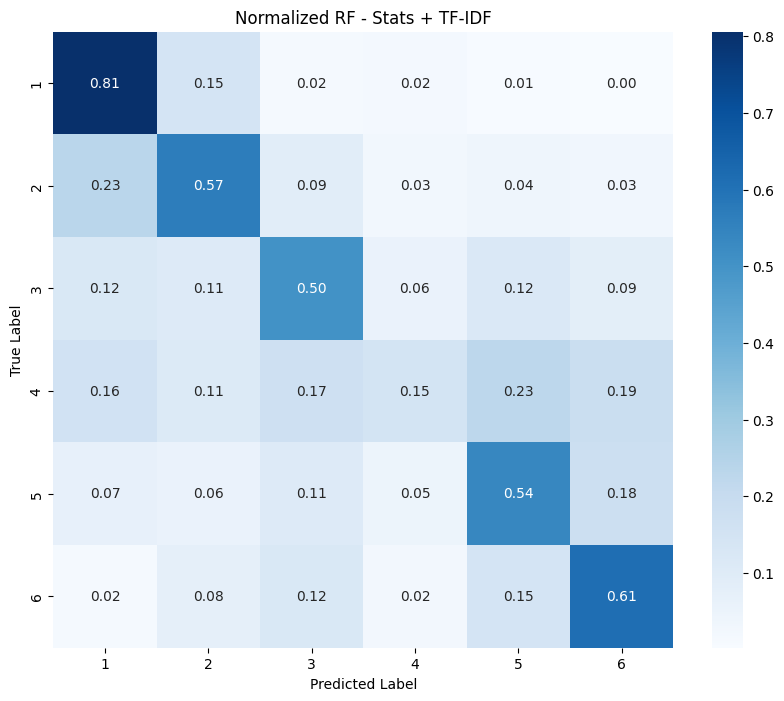

In [18]:
# Combine all feature matrices: Statistical + TF-IDF
X = hstack([
    X_stats_numeric,
    tfidf_matrix
]).tocsr()
y = df['Readability_Level_Encoded']
X_train_stats_Tfidf, X_test_stats_Tfidf, y_train_stats_Tfidf, y_test_stats_Tfidf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining RF with Statistical and TF-IDF ...")
rf_stats_Tfidf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_stats_Tfidf.fit(X_train_stats_Tfidf, y_train_stats_Tfidf)

# Evaluate
y_pred_stats_Tfidf = rf_stats_Tfidf.predict(X_test_stats_Tfidf)
print("\n Model Evaluation (Statistical and TF-IDF):")
print(classification_report(y_test_stats_Tfidf, y_pred_stats_Tfidf, digits=3))

acc_rf_stats_tfidf = accuracy_score(y_test_stats_Tfidf, y_pred_stats_Tfidf)
qwk_rf_stats_tfidf = calculate_qwk(y_test_stats_Tfidf, y_pred_stats_Tfidf)
acc1_rf_stats_tfidf = calculate_accuracy_within_one(y_test_stats_Tfidf, y_pred_stats_Tfidf)

print(f"Accuracy (Statistical and TF-IDF): {acc_rf_stats_tfidf:.4f}")
print(f"QWK (Statistical and TF-IDF): {qwk_rf_stats_tfidf:.4f}")
print(f"Accuracy ±1 (Statistical and TF-IDF): {acc1_rf_stats_tfidf:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_stats_Tfidf, y_pred_stats_Tfidf, class_names_labels, title='RF - Stats + TF-IDF')

## 10. Download NLTK Data

In [12]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 11. Word2Vec Embeddings and Random Forest Model


Training Word2Vec model...

Training RF with Word2Vec features...

 Word2Vec Model Evaluation:
              precision    recall  f1-score   support

           0      0.519     0.652     0.578      1559
           1      0.468     0.414     0.439      1552
           2      0.391     0.345     0.367      1543
           3      0.320     0.207     0.251      1519
           4      0.477     0.498     0.487      1589
           5      0.534     0.686     0.601      1520

    accuracy                          0.467      9282
   macro avg      0.452     0.467     0.454      9282
weighted avg      0.452     0.467     0.454      9282

Accuracy (Word2Vec): 0.4675
QWK (Word2Vec): 0.6385
Accuracy ±1 (Word2Vec): 0.7342


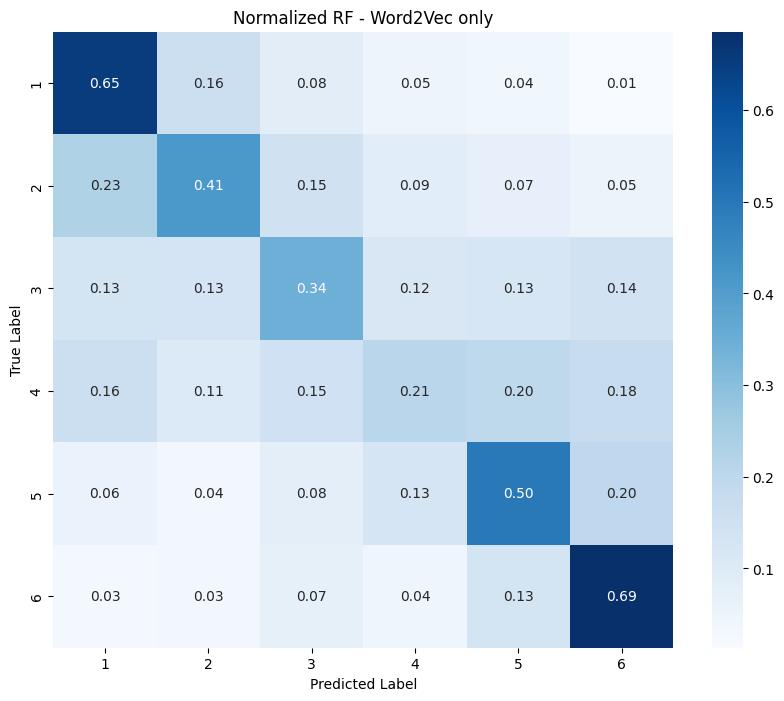

In [13]:
# Word2Vec Embeddings with default SVC
print("\nTraining Word2Vec model...")
tokenized_sentences = [word_tokenize(text) for text in df['Sentence'].astype(str)]
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=300, window=5, min_count=2, workers=4, sg=1)

def get_avg_vector(tokens, model, vector_size=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

X_w2v = np.array([get_avg_vector(tokens, w2v_model, 300) for tokens in tokenized_sentences])
y_w2v = df['Readability_Level_Encoded'].values
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.2, random_state=42)

print("\nTraining RF with Word2Vec features...")
rf_w2v = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_w2v.fit(X_train_w2v, y_train_w2v)

# Evaluate
y_pred_w2v = rf_w2v.predict(X_test_w2v)
print("\n Word2Vec Model Evaluation:")
print(classification_report(y_test_w2v, y_pred_w2v, digits=3))

acc_rf_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
qwk_rf_w2v = calculate_qwk(y_test_w2v, y_pred_w2v)
acc1_rf_w2v = calculate_accuracy_within_one(y_test_w2v, y_pred_w2v)

print(f"Accuracy (Word2Vec): {acc_rf_w2v:.4f}")
print(f"QWK (Word2Vec): {qwk_rf_w2v:.4f}")
print(f"Accuracy ±1 (Word2Vec): {acc1_rf_w2v:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_w2v, y_pred_w2v, class_names_labels, title='RF - Word2Vec only')

## 12. Random Forest Model - Statistical + Word2Vec Features


Training RF with Statistical and Word2vec...

 Model Evaluation:(Statistical and Word2vec)
              precision    recall  f1-score   support

           0      0.543     0.715     0.617      1559
           1      0.492     0.461     0.476      1552
           2      0.419     0.384     0.401      1543
           3      0.354     0.201     0.256      1519
           4      0.519     0.522     0.521      1589
           5      0.569     0.713     0.633      1520

    accuracy                          0.500      9282
   macro avg      0.483     0.499     0.484      9282
weighted avg      0.483     0.500     0.485      9282

Accuracy (Statistical and Word2vec): 0.4999
QWK (Statistical and Word2vec): 0.6979
Accuracy ±1 (Statistical and Word2vec): 0.7700


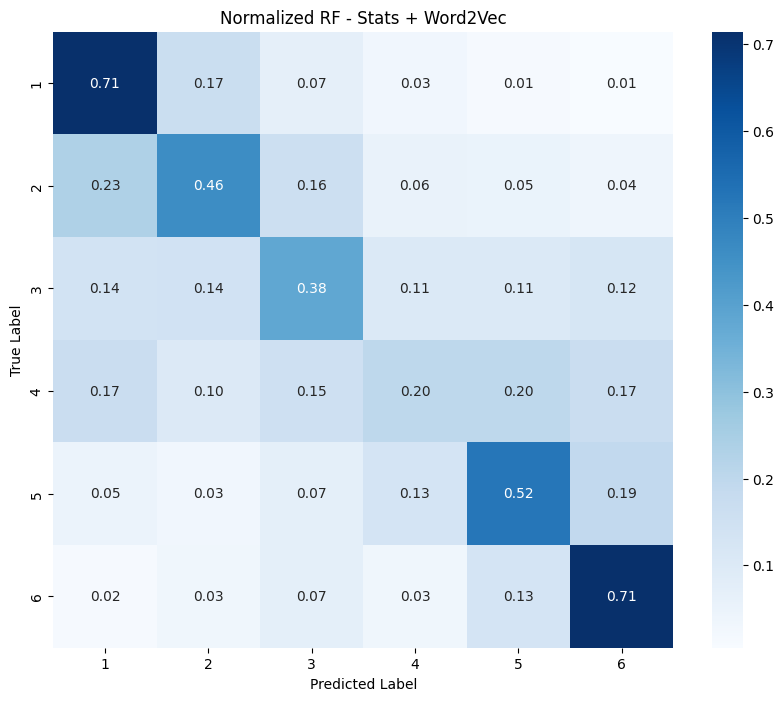

In [21]:
# Combine Statistical + Word2Vec Features
X_combined = np.hstack([X_stats, X_w2v])
y_combined = df['Readability_Level_Encoded'].values
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42
)

print("\nTraining RF with Statistical and Word2vec...")
rf_combined = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_combined.fit(X_train_c, y_train_c)

# Evaluate
y_pred_combined = rf_combined.predict(X_test_c)
print("\n Model Evaluation:(Statistical and Word2vec)")
print(classification_report(y_test_c, y_pred_combined, digits=3))

acc_rf_stats_w2v = accuracy_score(y_test_c, y_pred_combined)
qwk_rf_stats_w2v = calculate_qwk(y_test_c, y_pred_combined)
acc1_rf_stats_w2v = calculate_accuracy_within_one(y_test_c, y_pred_combined)

print(f"Accuracy (Statistical and Word2vec): {acc_rf_stats_w2v:.4f}")
print(f"QWK (Statistical and Word2vec): {qwk_rf_stats_w2v:.4f}")
print(f"Accuracy ±1 (Statistical and Word2vec): {acc1_rf_stats_w2v:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_c, y_pred_combined, class_names_labels, title='RF - Stats + Word2Vec')

## 13. Random Forest Model - AraBERT Embeddings


Training Random Forest with AraBERT Embeddings...

 Model Evaluation (Random Forest - AraBERT):
              precision    recall  f1-score   support

           0      0.578     0.739     0.649      1547
           1      0.509     0.542     0.525      1547
           2      0.425     0.361     0.390      1547
           3      0.425     0.255     0.319      1547
           4      0.529     0.610     0.567      1547
           5      0.724     0.765     0.744      1547

    accuracy                          0.545      9282
   macro avg      0.532     0.545     0.532      9282
weighted avg      0.532     0.545     0.532      9282

Accuracy (RF - AraBERT): 0.5451
QWK (RF - AraBERT): 0.7621
Accuracy ±1 (RF - AraBERT): 0.8188


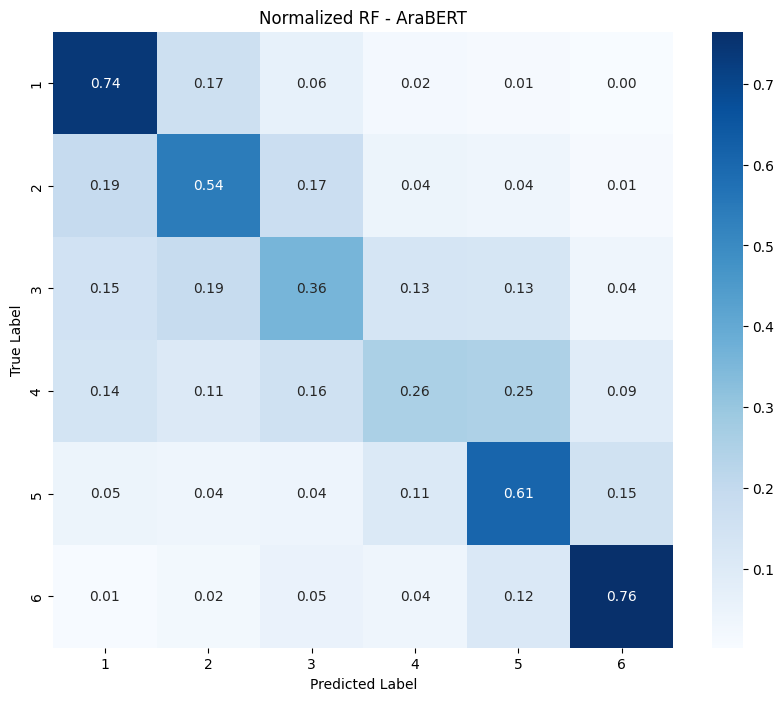

In [28]:
# Train Random Forest with AraBERT
print("\nTraining Random Forest with AraBERT Embeddings...")

rf_ara = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_ara.fit(X_train_pkl, y_train_pkl)

# Evaluate
y_pred_rf_ara = rf_ara.predict(X_test_pkl)
print("\n Model Evaluation (Random Forest - AraBERT):")
print(classification_report(y_test_pkl, y_pred_rf_ara, digits=3))

acc_rf_ara = accuracy_score(y_test_pkl, y_pred_rf_ara)
qwk_rf_ara = calculate_qwk(y_test_pkl, y_pred_rf_ara)
acc1_rf_ara = calculate_accuracy_within_one(y_test_pkl, y_pred_rf_ara)

print(f"Accuracy (RF - AraBERT): {acc_rf_ara:.4f}")
print(f"QWK (RF - AraBERT): {qwk_rf_ara:.4f}")
print(f"Accuracy ±1 (RF - AraBERT): {acc1_rf_ara:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_pkl, y_pred_rf_ara, class_names_labels, title='RF - AraBERT')

## 14. Model Performance Summary

In [36]:
import pandas as pd

model_results = {
    'Model': [
        'TF-IDF Only',
        'Statistical + TF-IDF',
        'Word2Vec Only',
        'Statistical + Word2Vec',
        'AraBERT Embeddings'
    ],
    '      Accuracy': [acc_rf_tfidf, acc_rf_stats_tfidf, acc_rf_w2v, acc_rf_stats_w2v, acc_rf_ara],
    '      QWK': [qwk_rf_tfidf, qwk_rf_stats_tfidf, qwk_rf_w2v, qwk_rf_stats_w2v, qwk_rf_ara],
    '   Accuracy ±1': [acc1_rf_tfidf, acc1_rf_stats_tfidf, acc1_rf_w2v, acc1_rf_stats_w2v, acc1_rf_ara]
}

results_df = pd.DataFrame(model_results)
for col in ['      Accuracy', '      QWK', '   Accuracy ±1']:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.4f}")

print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

acc_values = [acc_rf_tfidf, acc_rf_stats_tfidf, acc_rf_w2v, acc_rf_stats_w2v, acc_rf_ara]
qwk_values = [qwk_rf_tfidf, qwk_rf_stats_tfidf, qwk_rf_w2v, qwk_rf_stats_w2v, qwk_rf_ara]
acc1_values = [acc1_rf_tfidf, acc1_rf_stats_tfidf, acc1_rf_w2v, acc1_rf_stats_w2v, acc1_rf_ara]

print(f"\nBest Accuracy: {model_results['Model'][acc_values.index(max(acc_values))]} ({max(acc_values):.4f})")
print(f"Best QWK: {model_results['Model'][qwk_values.index(max(qwk_values))]} ({max(qwk_values):.4f})")
print(f"Best Accuracy ±1: {model_results['Model'][acc1_values.index(max(acc1_values))]} ({max(acc1_values):.4f})")



PERFORMANCE SUMMARY
                 Model       Accuracy       QWK    Accuracy ±1
           TF-IDF Only         0.4682    0.6055         0.7053
  Statistical + TF-IDF         0.5295    0.6838         0.7644
         Word2Vec Only         0.4675    0.6385         0.7342
Statistical + Word2Vec         0.4999    0.6979         0.7700
    AraBERT Embeddings         0.5451    0.7621         0.8188

Best Accuracy: AraBERT Embeddings (0.5451)
Best QWK: AraBERT Embeddings (0.7621)
Best Accuracy ±1: AraBERT Embeddings (0.8188)


Final code